In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.impute import KNNImputer

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Kaliningrad_weather_19102020_15102011.csv', encoding = "windows-1251",  sep=";")

In [ ]:
df['DD_binary']=0
for k in range(0, len(df['DD'])):
  if df['DD'].iloc[k]=='Ветер':
    df['DD_binary'].iloc[k]=1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df=df.drop(columns=['DD'], axis=1)
df=df.dropna()

In [ ]:
df=df[['LocalTime', 'T']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler=MinMaxScaler()

df_norm=df['T'].values
df_norm=MinMaxScaler.fit_transform(df_norm.reshape(-1,1))
df_norm=df_norm.flatten()

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# min_max_scaler = MinMaxScaler()

# df_norm  = df['U'].values
# df_norm = min_max_scaler.fit_transform(df_norm.reshape(-1,1))
# df_norm = df_norm.flatten()
# print(df_norm)

In [ ]:
window = 40
n_samples = df_norm.shape[0]-window

n_train_samples = 14000
n_val_samples = 4000
n_test_samples = n_samples-n_train_samples-n_val_samples
print(n_test_samples)

3758


In [ ]:
X_train=np.zeros((n_train_samples,window))
y_train=np.zeros(n_train_samples)

X_val=np.zeros((n_val_samples,window))
y_val=np.zeros(n_val_samples)

X_test=np.zeros((n_test_samples,window))
y_test=np.zeros(n_test_samples)

In [ ]:
for i in range(n_train_samples):
  
  for j in range(window):
    X_train[i,j] = df_norm[i+j]

  y_train[i] = df_norm[i+window]

for i in range(n_val_samples):

  for j in range(window):
    X_val[i,j] = df_norm[n_train_samples+i+j]

  y_val[i] = df_norm[n_train_samples+i+window]

for i in range(n_test_samples):

  for j in range(window):
    X_test[i,j] = df_norm[n_train_samples+n_val_samples+i+j]

  y_test[i] = df_norm[n_train_samples+n_val_samples+i+window]

In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

model = Sequential()
model.add(LSTM(2,input_shape=(window,1)))
model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam',loss='mse',metrics='mae')

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2)                 32        
                                                                 
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 100
batch_size = 20

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_data = (X_val,y_val))

Epoch 1/100
700/700 [==============================] - 10s 12ms/step - loss: 0.0590 - mae: 0.1782 - val_loss: 0.0125 - val_mae: 0.0894
Epoch 2/100
700/700 [==============================] - 9s 13ms/step - loss: 0.0053 - mae: 0.0554 - val_loss: 0.0047 - val_mae: 0.0531
Epoch 3/100
700/700 [==============================] - 7s 10ms/step - loss: 0.0037 - mae: 0.0461 - val_loss: 0.0045 - val_mae: 0.0522
Epoch 4/100
700/700 [==============================] - 8s 11ms/step - loss: 0.0036 - mae: 0.0452 - val_loss: 0.0044 - val_mae: 0.0514
Epoch 5/100
700/700 [==============================] - 7s 10ms/step - loss: 0.0035 - mae: 0.0444 - val_loss: 0.0043 - val_mae: 0.0511
Epoch 6/100
700/700 [==============================] - 7s 10ms/step - loss: 0.0033 - mae: 0.0435 - val_loss: 0.0041 - val_mae: 0.0494
Epoch 7/100
700/700 [==============================] - 8s 11ms/step - loss: 0.0032 - mae: 0.0425 - val_loss: 0.0039 - val_mae: 0.0481
Epoch 8/100
700/700 [==============================] - 8s 11m

In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = MinMaxScaler.inverse_transform(y_pred)
y_test_inv = MinMaxScaler.inverse_transform(y_test.reshape(-1,1))

118/118 [==============================] - 1s 4ms/step


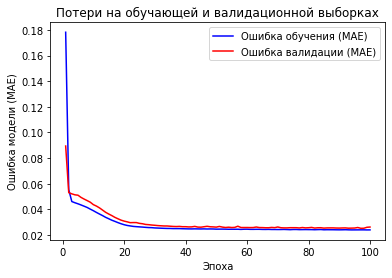

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,mae,color='blue',label='Ошибка обучения (MAE)')
plt.plot(epochs,val_mae,color='red',label='Ошибка валидации (MAE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MAE)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error
print(f'R2 Score (Test) = {round(r2_score(y_true=y_test_inv,y_pred=y_pred_inv),3)}',f'MAE (Test) = {round(mean_absolute_error(y_true=y_test_inv, y_pred=y_pred_inv),3)}', sep='\n')

R2 Score (Test) = 0.956
MAE (Test) = 1.304
